Using TensorFlow backend.
/data/xai/xai-genz/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/data/xai/xai-genz/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/data/xai/xai-genz/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/data/xai/xai-genz/venv/lib/python3.6/site-packages/t

10000 test samples


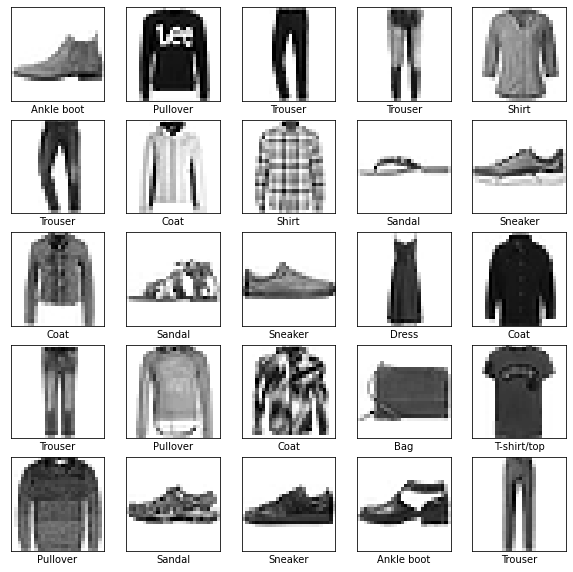

In [1]:
import numpy as np
import keras
import matplotlib.pyplot as plt
%matplotlib inline

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# input image dimensions
img_rows, img_cols = 28, 28

# the data, shuffled and split between train and test sets
(_, _), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1).astype('float32')
x_test /= 255

print(x_test.shape[0], 'test samples')

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_test[i].reshape(img_rows, img_cols), cmap=plt.cm.binary)
    plt.xlabel(class_names[y_test[i]])
plt.show()

In [2]:
from keras.models import load_model

model = load_model('fashion_mnist-gs.h5')
print(model.summary())



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)            

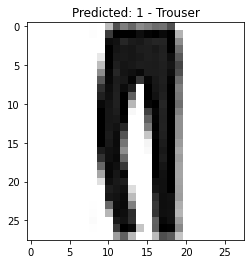

In [4]:
import random

random_idx = random.choice(range(len(x_test)))
to_explain_img = x_test[random_idx]
to_explain_label = int(y_test[random_idx])

plt.figure()
plt.title(f'Predicted: {to_explain_label} - {class_names[to_explain_label]}')
plt.imshow(to_explain_img.reshape(img_rows, img_cols), cmap=plt.cm.binary)
plt.grid(False)
plt.show()

# KERAS-VIZ

In [5]:
from vis.utils import utils
from keras import activations

# Utility to search for layer index by name. 
# Alternatively we can specify this as -1 since it corresponds to the last layer.
layer_idx = utils.find_layer_idx(model, 'preds')

# Swap softmax with linear
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## ACTIVATION LAYERS

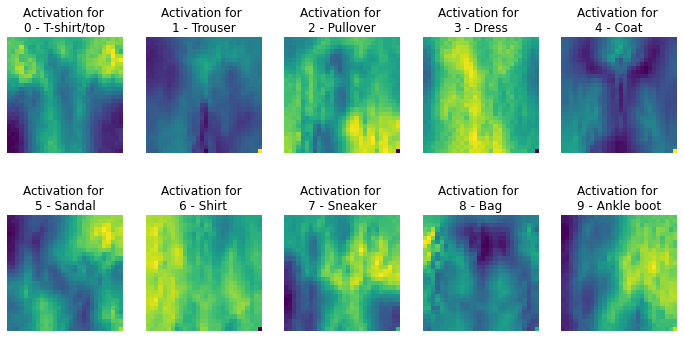

In [6]:
from vis.visualization import visualize_activation

# show activation areas for each class
fig, m_axs = plt.subplots(2,5, figsize = (12,6))
for i, c_ax in enumerate(m_axs.flatten()):
    img = visualize_activation(model, layer_idx, filter_indices=i)
    c_ax.imshow(img[..., 0])
    c_ax.set_title(f'Activation for \n{i} - {class_names[i]}')
    c_ax.axis('off')

## SALIENCY

Text(0.5, 1.0, 'Saliency for Trouser')

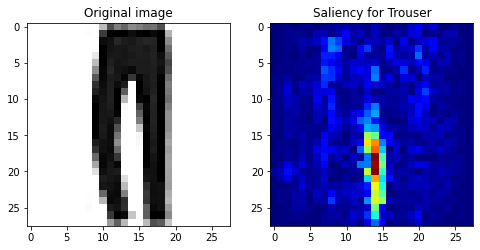

In [7]:
from vis.visualization import visualize_saliency

grads = visualize_saliency(model, layer_idx, filter_indices=to_explain_label, seed_input=to_explain_img)

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (8, 4))
ax1.imshow(to_explain_img.reshape(img_rows, img_cols), cmap=plt.cm.binary)
ax1.set_title('Original image')

ax2.imshow(grads, cmap='jet')
ax2.set_title('Saliency for {}'.format(class_names[to_explain_label]))

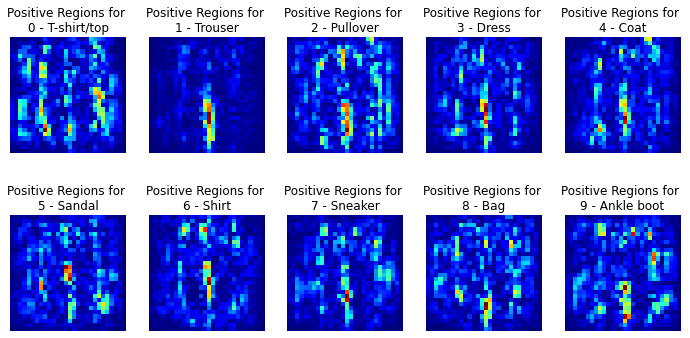

In [8]:
# now show them for each class
fig, m_axs = plt.subplots(2,5, figsize = (12,6))
for i, c_ax in enumerate(m_axs.flatten()):
    grads = visualize_saliency(model, layer_idx, filter_indices=i, seed_input=to_explain_img)
    c_ax.imshow(grads, cmap='jet')
    c_ax.set_title(f'Positive Regions for \n{i} - {class_names[i]}')
    c_ax.axis('off')

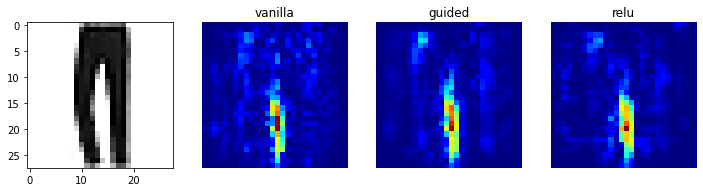

In [11]:
# now show them for backprop modifier
f, ax = plt.subplots(1, 4, figsize = (12,6))
ax[0].imshow(to_explain_img.reshape(img_rows, img_cols), cmap=plt.cm.binary)
for i, modifier in enumerate([None, 'guided', 'relu']):
    grads = visualize_saliency(model, layer_idx, filter_indices=to_explain_label, 
                                   seed_input=to_explain_img, backprop_modifier=modifier)
    if modifier is None:
        modifier = 'vanilla'
    ax[i+1].imshow(grads, cmap='jet')
    ax[i+1].set_title(modifier)
    ax[i+1].axis('off')

# grad-CAM - vanilla, guided, rectified

Text(0.5, 1.0, 'Gradcam for Trouser')

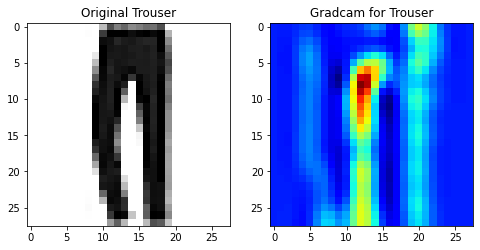

In [10]:
from vis.visualization import visualize_cam

grads = visualize_cam(model, layer_idx, filter_indices=0, seed_input=to_explain_img)

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (8, 4))
ax1.imshow(to_explain_img.reshape(img_rows, img_cols), cmap=plt.cm.binary)
ax1.set_title(f'Original {class_names[to_explain_label]}')

ax2.imshow(grads, cmap='jet')
ax2.set_title('Gradcam for {}'.format(class_names[to_explain_label]))

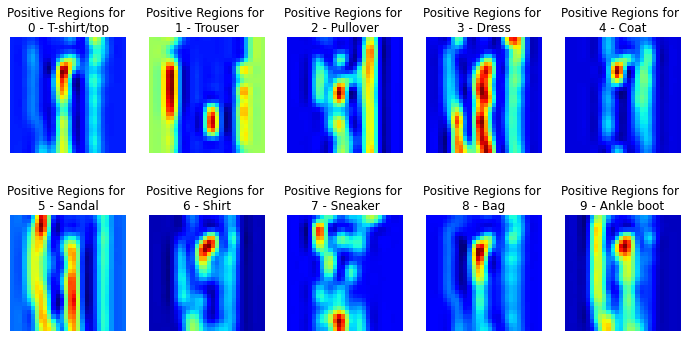

In [12]:
# now show them for each class
fig, m_axs = plt.subplots(2,5, figsize = (12,6))
for i, c_ax in enumerate(m_axs.flatten()):
    grads = visualize_cam(model, layer_idx, filter_indices=i, seed_input=to_explain_img)
    c_ax.imshow(grads, cmap='jet')
    c_ax.set_title(f'Positive Regions for \n{i} - {class_names[i]}')
    c_ax.axis('off')

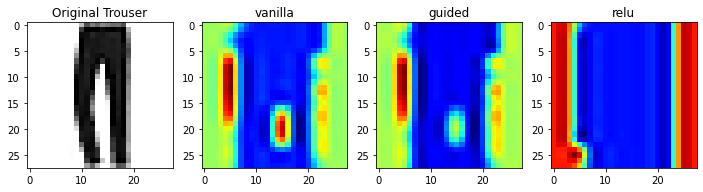

In [13]:
f, ax = plt.subplots(1, 4, figsize = (12,6))
ax[0].imshow(to_explain_img.reshape(img_rows, img_cols), cmap=plt.cm.binary)
ax[0].set_title(f'Original {class_names[to_explain_label]}')

for i, modifier in enumerate([None, 'guided', 'relu']):
    grads = visualize_cam(model, layer_idx, filter_indices=to_explain_label, 
                          seed_input=to_explain_img, backprop_modifier=modifier)        
    if modifier is None:
        modifier = 'vanilla'
    ax[i+1].set_title(modifier)    
    ax[i+1].imshow(grads, cmap='jet')